In [1]:
# Load necessary packages and tools

# System
import os
import sys
import glob

# Data/analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100 # See all of the columns when DFs are displayed

# Util functions
from priority_tools import * # Implementation details and comments can be found in this file
from X_ranking import get_X_ranked_df

from plotting_tools import bin_plotter_new

# Plotting (with fancy font/backend output)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high quality figures

%load_ext autoreload
%autoreload 2

In [3]:
# Load the TOIs that are ranked by the prioritization algorithm using TSM/t_HIRES
selected_toi_targets_df = pd.read_csv('data/sc3_target_lists/sc3_target_list_2020-07-21.csv')
selected_toi_targets_df = selected_toi_targets_df.set_index(['radius_bin', 'insol_bin', 'st_Teff_bin']).sort_index()

# Known transiting planets with masses from ExoArchive
kps_all = pd.read_csv('data/known_planets/known_planets.csv')

# Known transiting planets with masses from Exoplanet Archive with a TSM that is at least 0.5 * the best TSM in bin
kps_good_TSM_and_mass_df = pd.read_csv('data/known_planets/kps_w_good_TSM_in_bin_2020-07-21.csv')
kps_good_TSM_and_mass_df = kps_good_TSM_and_mass_df.set_index(['radius_bin', 'insol_bin', 'st_Teff_bin']).sort_index()

# Concatenate TOIs with known planets that have good TSMs
tois_and_kp_good_TSM_mass_flag_1_df = pd.concat((selected_toi_targets_df, kps_good_TSM_and_mass_df), sort=False)

# TOIs but only those with ranking >= 5
selected_toi_targets_df_ranked = selected_toi_targets_df[pd.notnull(selected_toi_targets_df['X_priority'])]

# Concatenate the TOIs with ranking >= 5 with the known planets that have good TSMs
selected_toi_targets_df_ranked_w_kps = pd.concat((selected_toi_targets_df_ranked, kps_good_TSM_and_mass_df), 
                                                 sort=False)

In [12]:
# Members of SC3 program on Jump
sc3_sample_tois = [266.01, 266.02, 421.01, 431.01, 431.02, 442.01, 469.01, 509.01, 554.01, 561.02, 620.01, 669.01, 
                   1136.03, 1194.01, 1247.01, 1339.01, 1339.02, 1410.01, 1430.01, 1471.01, 
                   1473.01, 1736.01, 1759.01, 1835.01, 2018.01]
sc3_sample = selected_toi_targets_df[selected_toi_targets_df['Full TOI ID'].isin(sc3_sample_tois)]

# Concatenate SC3 Jump program with known planets that have a good TSM
sc3_sample_w_kps = pd.concat((sc3_sample, kps_good_TSM_and_mass_df), sort=False)

In [13]:
# Add missing rows by hand for a couple of systems in the SC3 Jump program
toi_plus_list = pd.read_csv('data/toi/toi+-2020-07-21.csv', comment='#')
for toi,tsm,bins in zip([431.01, 431.02, 620.01], [216.1, 23., 104.], [(3,3,2), (1,5,2), (3,2,1)]):
    row = toi_plus_list[toi_plus_list['Full TOI ID'] == toi]
    row['TSM'] = tsm # From SG2/SG4
    row['radius_bin'], row['insol_bin'], row['st_Teff_bin'] = bins
    row = row.set_index(['radius_bin', 'insol_bin', 'st_Teff_bin']).sort_index()
    sc3_sample = pd.concat((sc3_sample, row), sort=False)

/Users/josephmurphy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/josephmurphy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Difference between our SC3 sample and planets that get ranked in latest run of prioritization algorithm
in_prio_AND_in_sc3_sample = selected_toi_targets_df_ranked[selected_toi_targets_df_ranked['Full TOI ID']\
                                                         .isin(sc3_sample['Full TOI ID'])]
in_prio_AND_NOT_in_sc3_sample = selected_toi_targets_df_ranked[~selected_toi_targets_df_ranked['Full TOI ID']\
                                                                .isin(sc3_sample['Full TOI ID'])]
in_sc3_sample_AND_NOT_in_prio = sc3_sample[~sc3_sample['Full TOI ID']\
                                           .isin(selected_toi_targets_df_ranked['Full TOI ID'])]

In [34]:
# Define the parameter space bins
rad_bins = 10**(np.linspace(0,1,6)) 
rad_bins[-1] = 11.2 #want to include up to Jupiter radius 
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

def plot_bins(data, all_known_planets=None, use_alpha=False):
    
    # For each radius bin
    for i in np.arange(1,6):
        # bin_plotter() function found in priority_tools.py file
        fig, ax = bin_plotter(data.rename(columns={'X_priority':'priority'}), 
                              bins, 
                              i, 
                              use_alpha=use_alpha, 
                              save_fig=False, show_fig=False)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        
        # Highlight TOIs that appear in the prioritization output but are not in SC3 Jump program
        curr_rad_bin = in_prio_AND_NOT_in_sc3_sample[in_prio_AND_NOT_in_sc3_sample['Planet Radius Value']\
                                                         .between(rad_bins[i-1], rad_bins[i])]
        ax.semilogx(curr_rad_bin['Effective Stellar Flux Value'], 
                   curr_rad_bin['Effective Temperature Value'], 
                   '*', 
                   color='orange', 
                   alpha=1.0, 
                   zorder=1000)
        
        # Optionally plot all known transiting planets with mass measurements in background
        if all_known_planets is not None:
            curr_rad_bin = all_known_planets[all_known_planets['Planet Radius Value']\
                                             .between(rad_bins[i-1], rad_bins[i])]
            ax.semilogx(curr_rad_bin['Effective Stellar Flux Value'], 
                       curr_rad_bin['Effective Temperature Value'], 
                       '.', 
                       color='black', 
                       alpha=0.3, 
                       zorder=-100)
            # Annontate the known planets with their name
            for index, row in curr_rad_bin.iterrows():
                ax.annotate(row['Full TOI ID'], 
                            (row['Effective Stellar Flux Value'], 
                             row['Effective Temperature Value']), 
                            textcoords='offset points',
                            xytext=(-5,5), 
                            ha='left', 
                            clip_on=True, 
                            alpha=0.3, 
                            zorder=-100)
                
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        
        plt.show()

/Users/josephmurphy/Documents/UCSC/research/2019-20/tks_target_shared/priority_tools.py:762: PerformanceWarning: indexing past lexsort depth may impact performance.
  size = len(binned_data.loc[rbin,f,t])


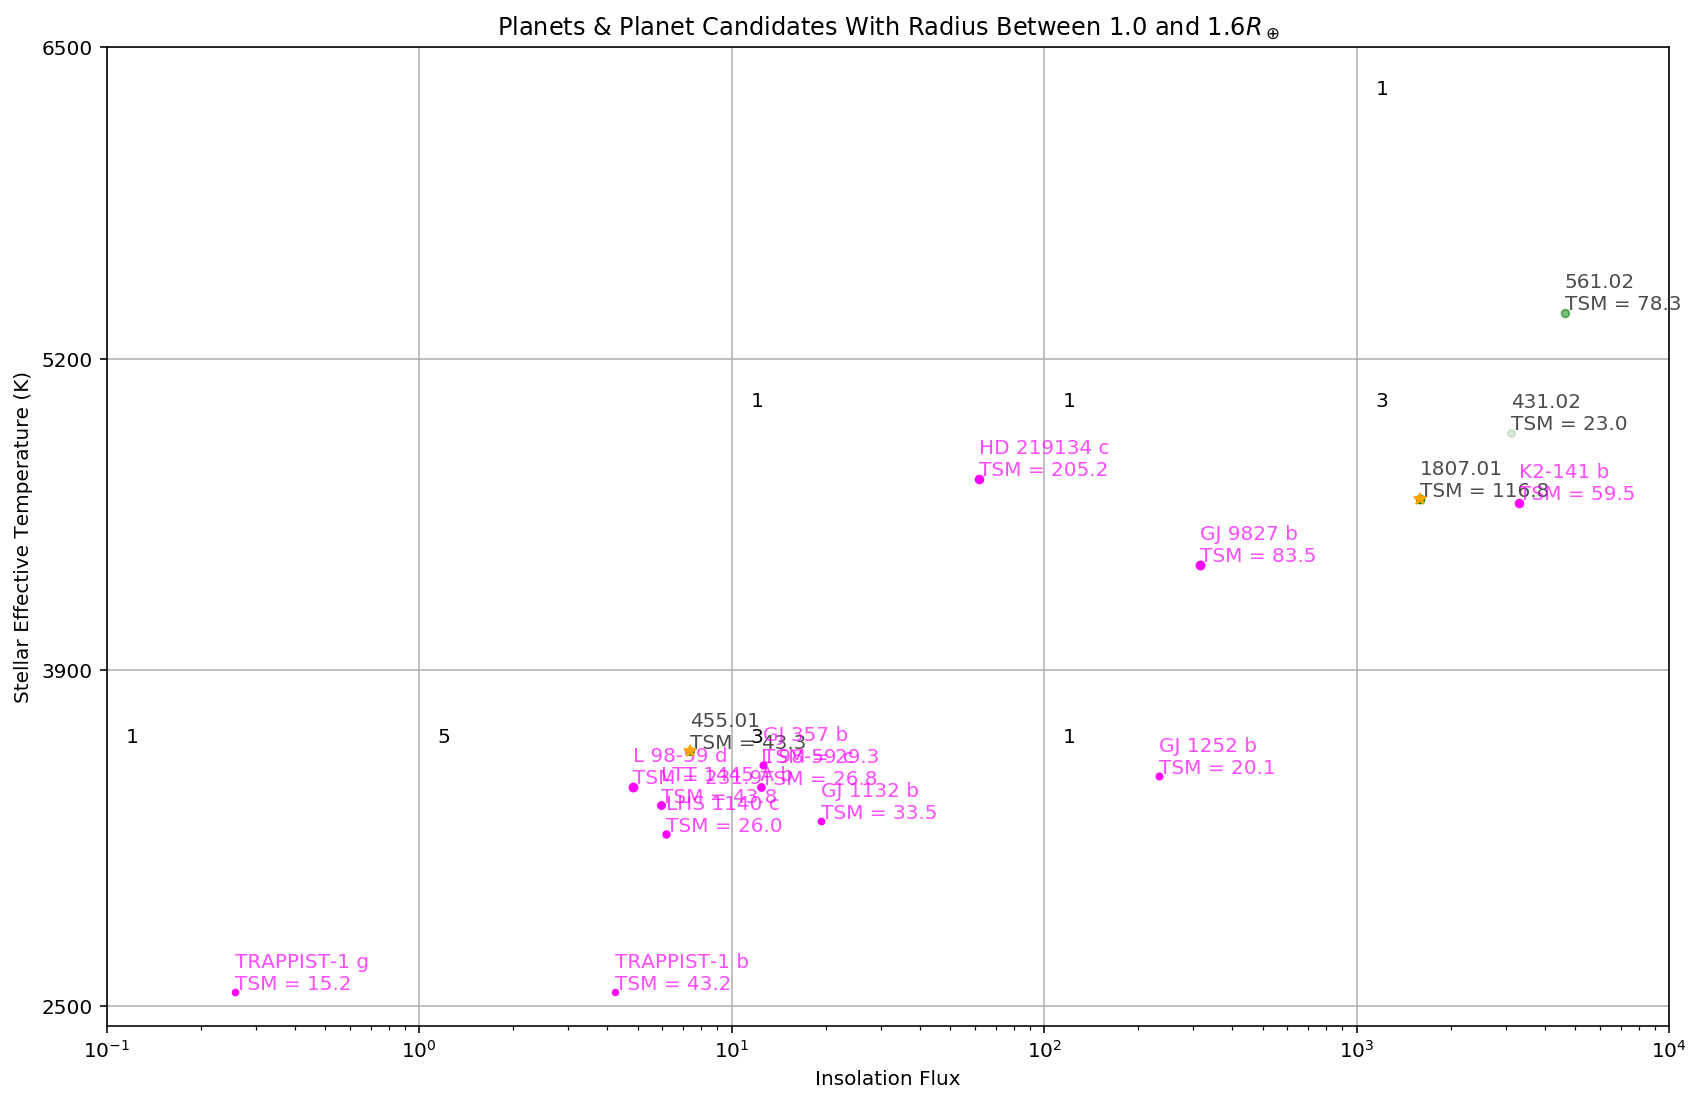

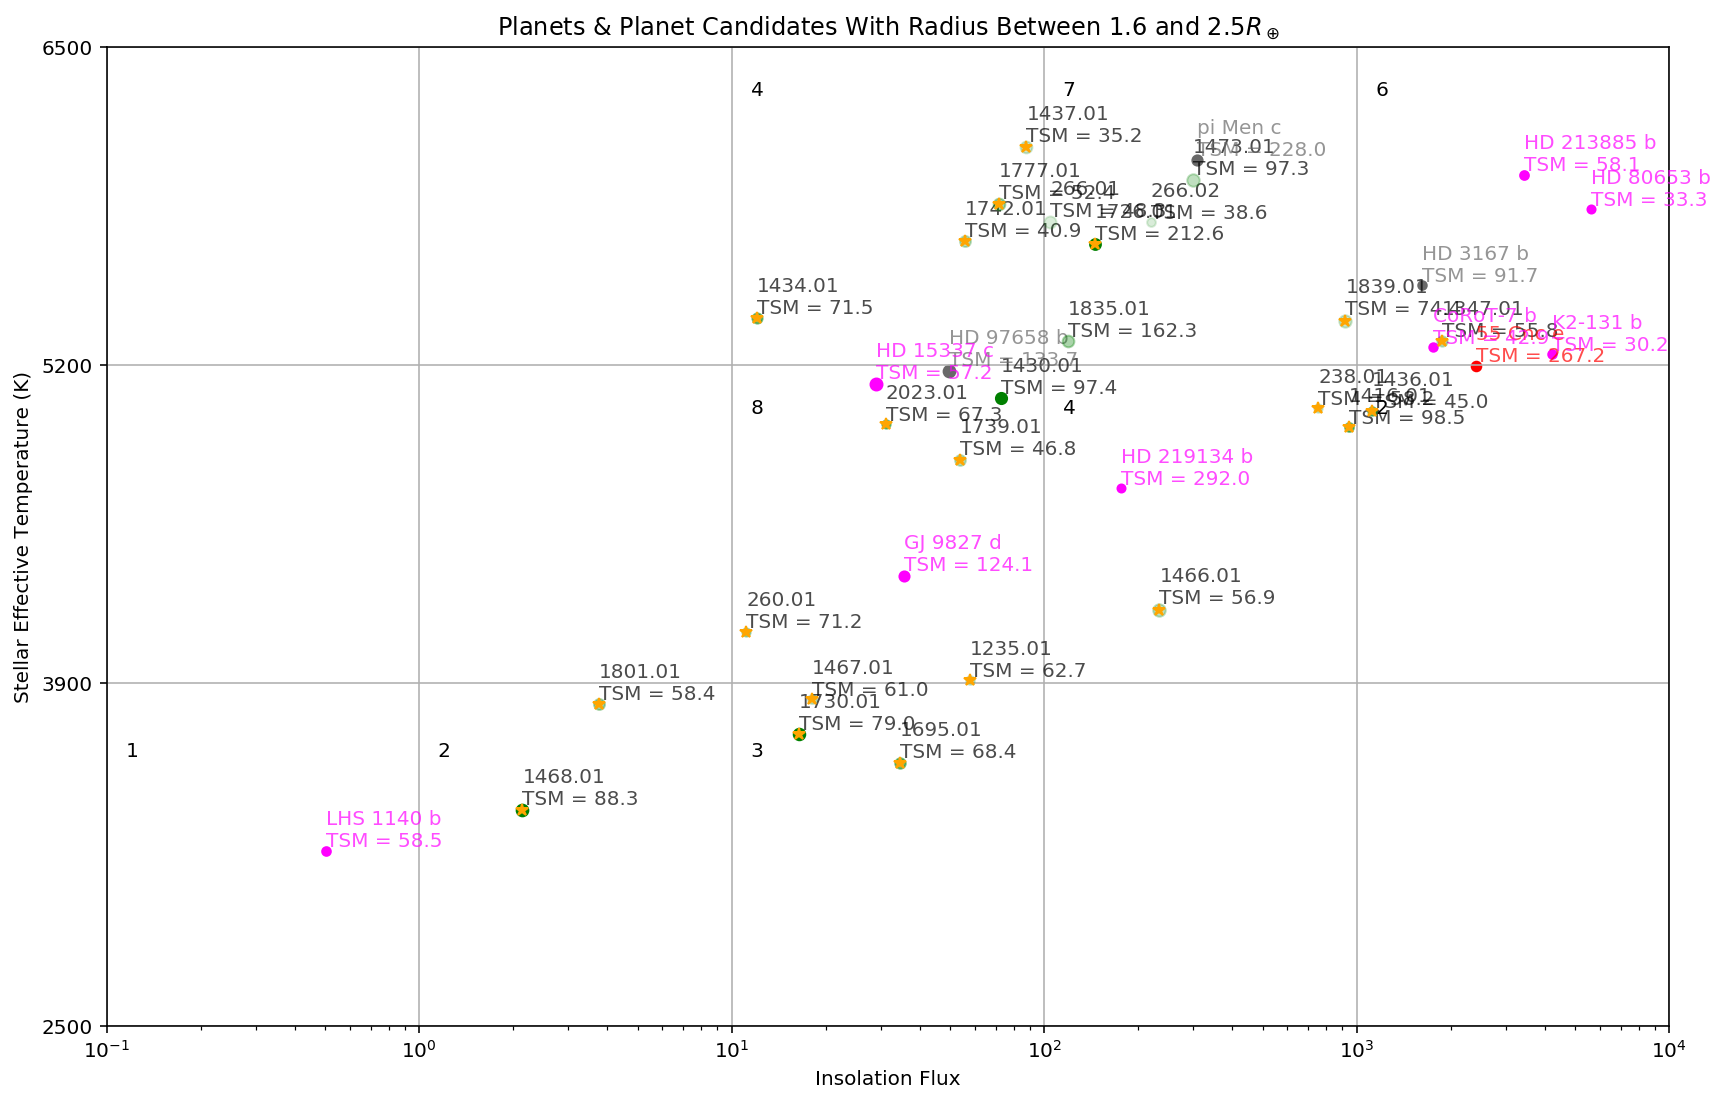

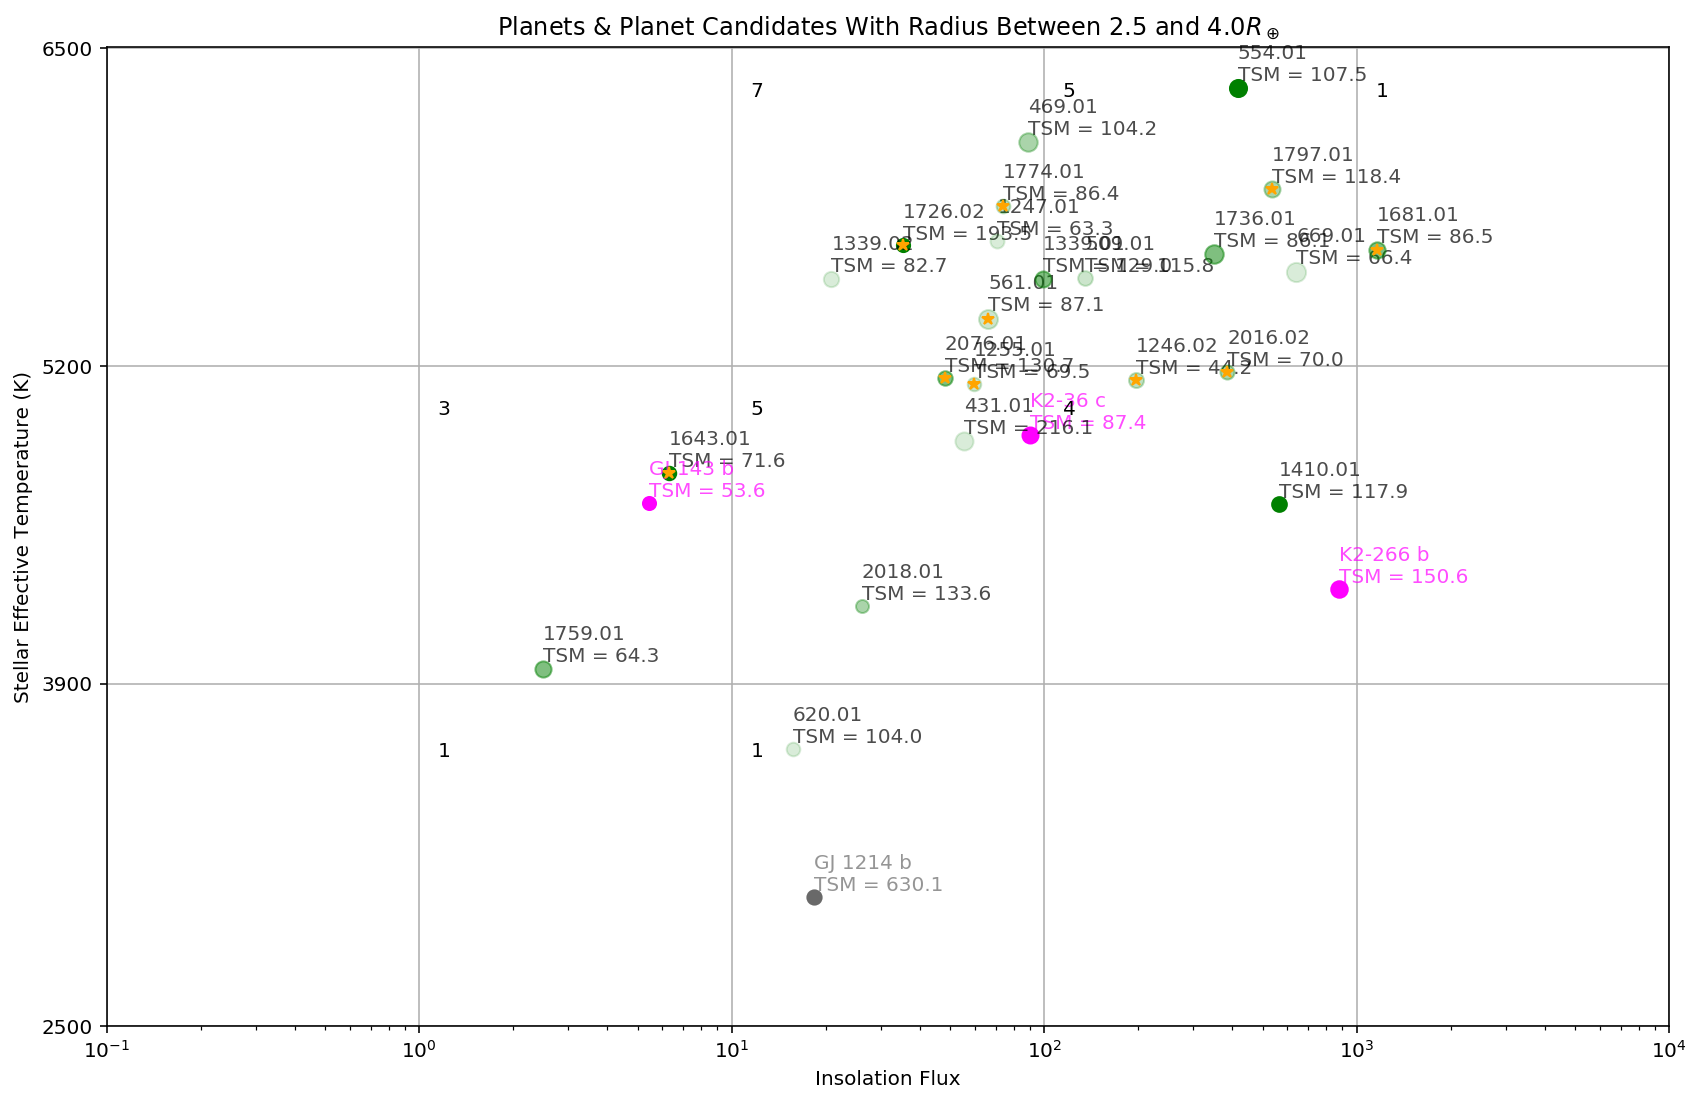

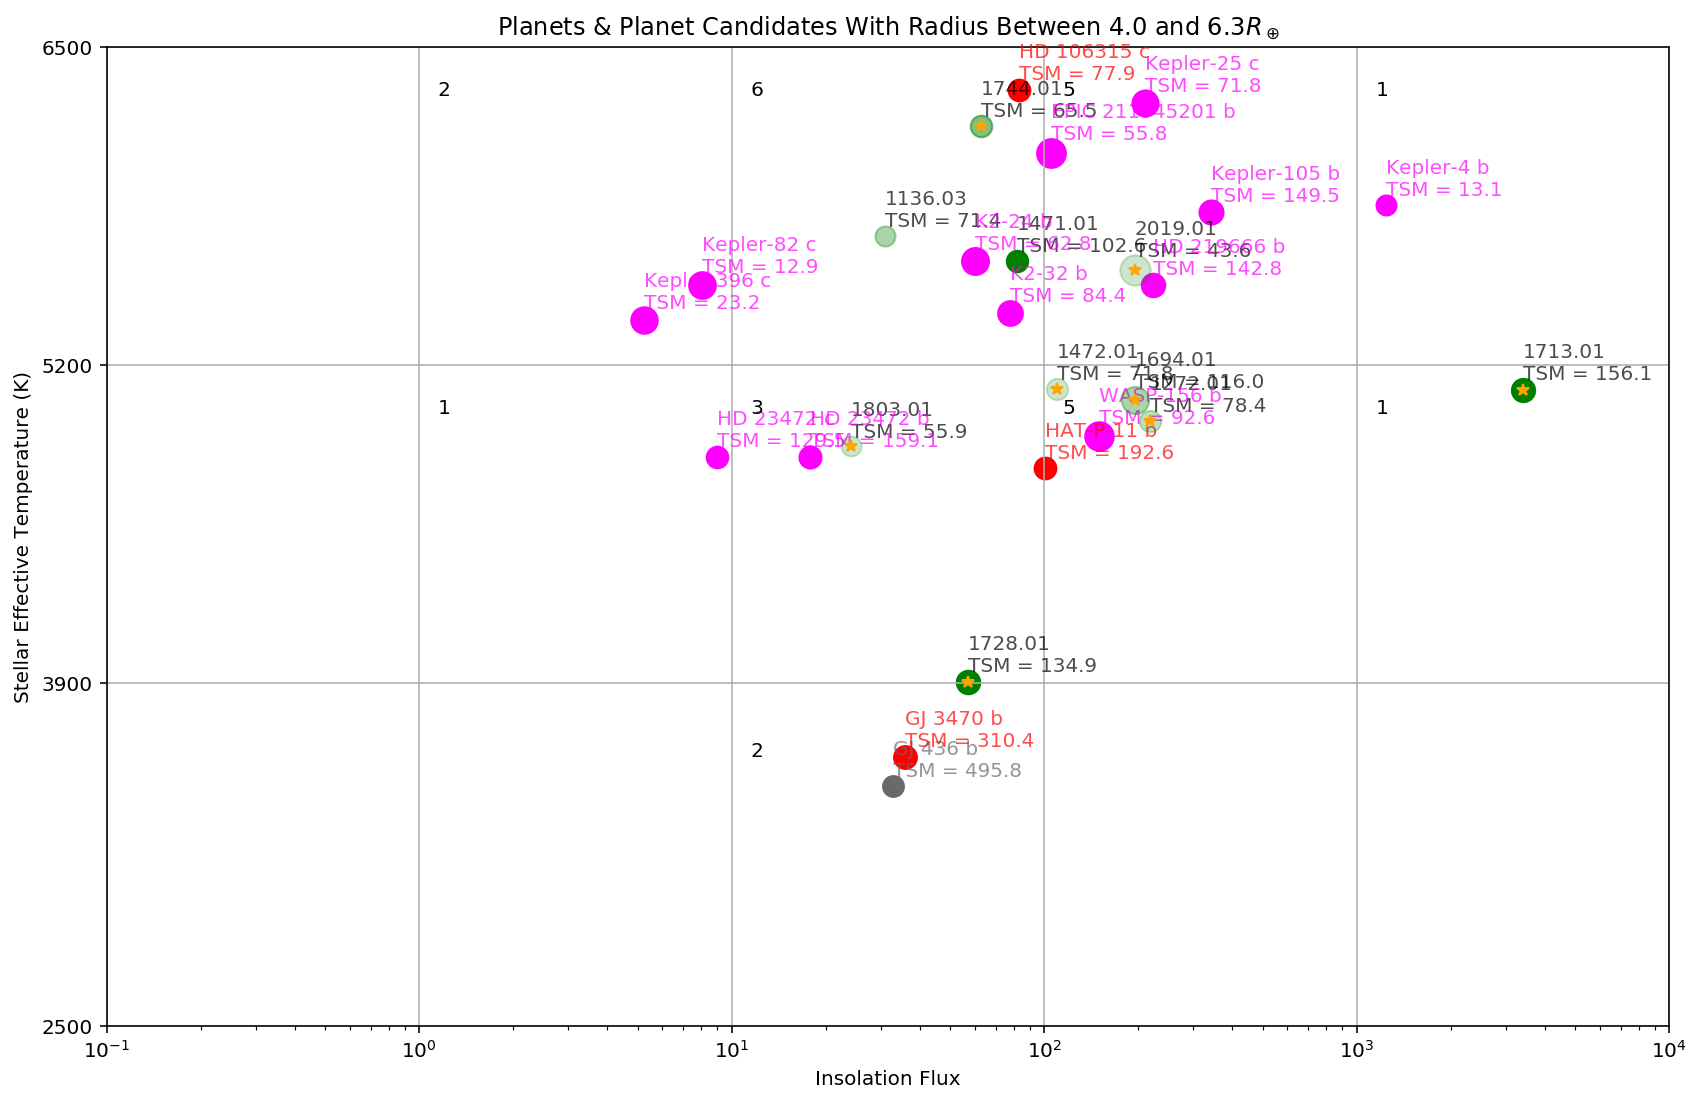

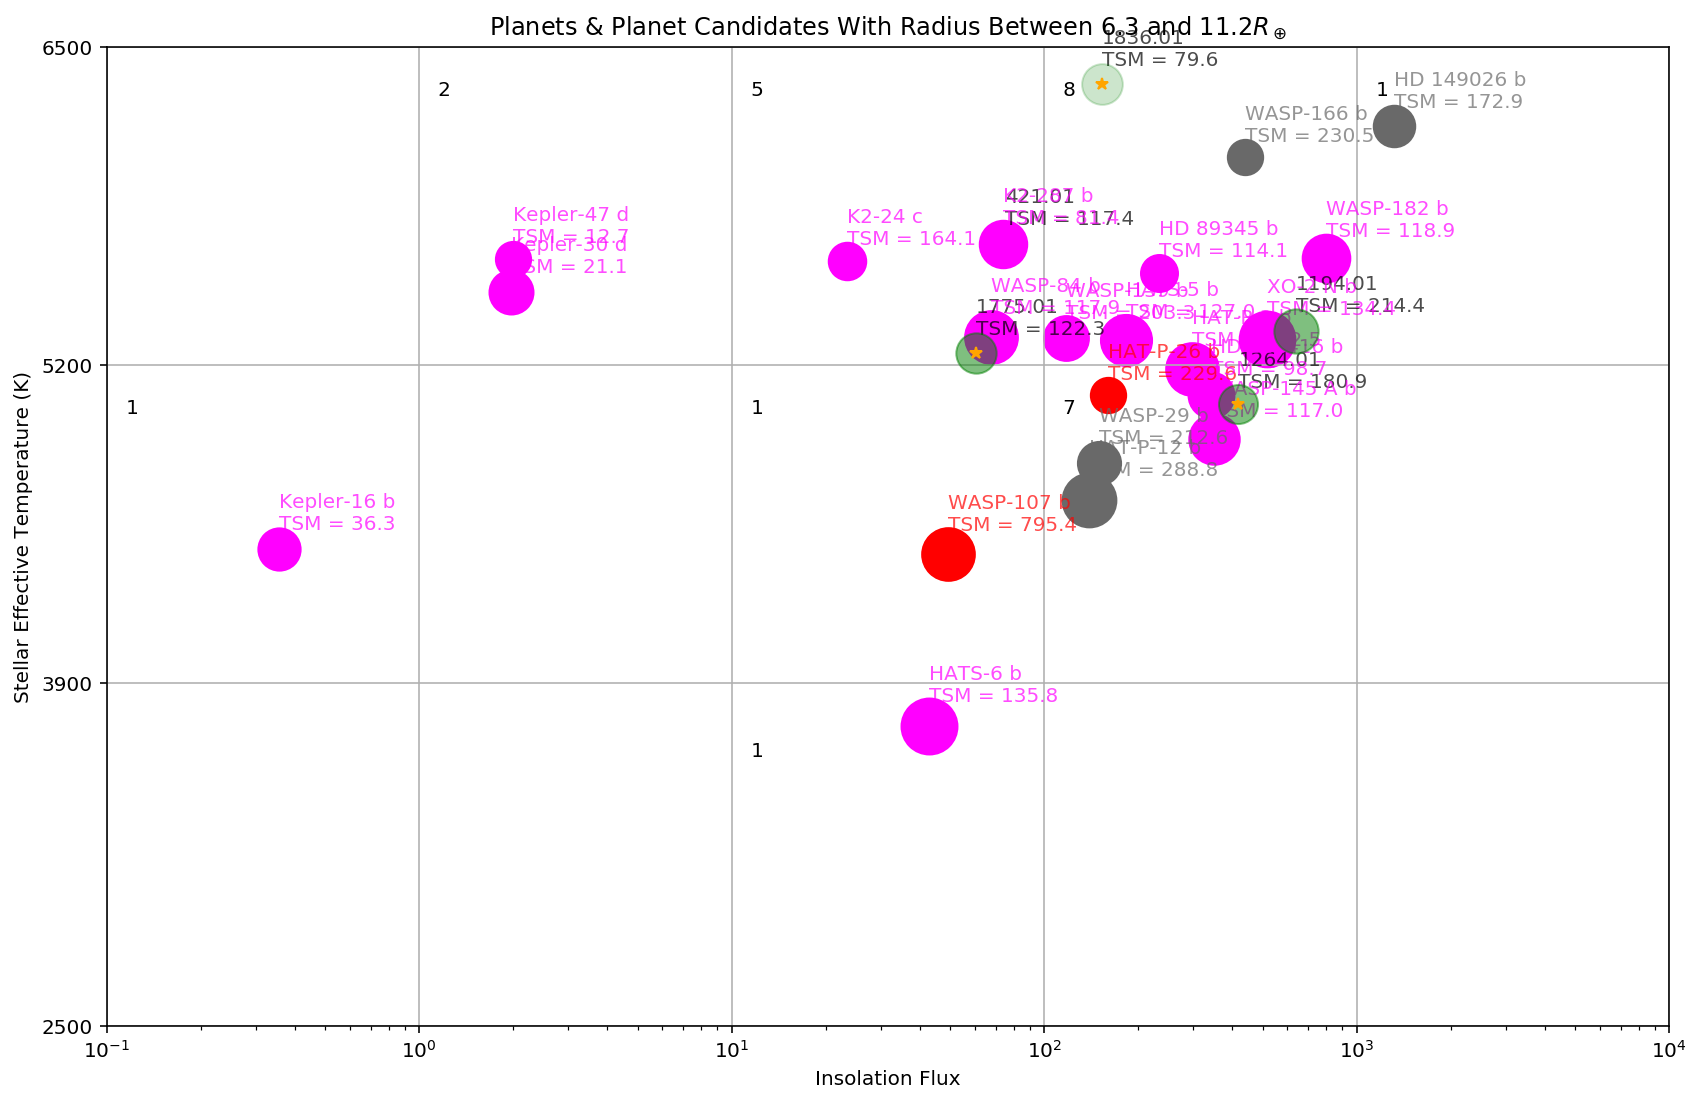

In [42]:
# A plot of known planets (gray), 
# known planets with TSM at least 0.5 * the best TSM in a bin (magenta), 
# and SC3 TOI candidates (green)
plot_with_all_kps = False

data = pd.concat((selected_toi_targets_df_ranked_w_kps, sc3_sample), sort=False)
data = data.drop_duplicates(subset='Full TOI ID')

if plot_with_all_kps:
    plot_bins(data, 
              kps_all[~kps_all['Full TOI ID'].isin(selected_toi_targets_df_ranked_w_kps['Full TOI ID'])], 
              use_alpha=True)
else:
    plot_bins(data, 
          None, 
          use_alpha=True)

In [40]:
# The list of TOIs that appear in the prioritization output but not in the SC3 Jump program
in_prio_AND_NOT_in_sc3_sample

Source Pipeline  Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                
1          2         1                      spoc       455.01   
           5         2                      spoc      1807.01   
2          2         1                      spoc      1468.01   
                     1                      spoc      1801.01   
           3         1                      spoc      1730.01   
                     1                      spoc      1695.01   
                     1                      spoc      1467.01   
                     2                      spoc       260.01   
                     2                      spoc      2023.01   
                     2                      spoc      1235.01   
                     2                      spoc      1739.01   
                     3                      spoc      1434.01   
                     3                      spoc      1777.01   
                     3                      spoc      1742.01   
                     3                      spoc      1437.01   
           4         2                      spoc      1416.01   
                     2                      spoc       238.01   
                     2                      spoc      1466.01   
                     3                      spoc      1726.01   
                     3                      spoc      1839.01   
           5         2                      spoc      1436.01   
                     3                      spoc      1347.01   
3          2         2                      spoc      1643.01   
           3         2                      spoc      2076.01   
                     2                      spoc      1255.01   
                     3                      spoc      1726.02   
                     3                      spoc       561.01   
                     3                      spoc      1774.01   
           4         2                      spoc      2016.02   
                     2                      spoc      1246.02   
                     3                      spoc      1797.01   
           5         3                      spoc      1681.01   
4          3         2                      spoc      1728.01   
                     2                      spoc      1803.01   
                     3                      spoc      1744.01   
           4         2                      spoc      1694.01   
                     2                      spoc      1272.01   
                     2                      spoc      1472.01   
                     3                      spoc      2019.01   
           5         2                      spoc      1713.01   
5          3         3                      spoc      1775.01   
           4         2                      spoc      1264.01   
                     3                      spoc      1836.01   

                                  Planet Radius Value  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                                              
1          2         1                       1.368307              5.358807   
           5         2                       1.525893              0.549343   
2          2         1                       2.333273             15.531925   
                     1                       2.170286             21.284406   
           3         1                       2.299128              6.222236   
                     1                       2.085673              3.131463   
                     1                       1.827003              5.973384   
                     2                       1.637881             13.470018   
                     2                       1.660818             11.190049   
                     2                       1.726500              3.444703   
                     2                       2.145596              8.303966   
                     3                       2.029456             29.889399   
 

In [41]:
# Planets in the SC3 Jump program
sc3_sample

Source Pipeline  Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                
1          5         3                      spoc       561.02   
2          3         2                      spoc      1430.01   
           4         3                      spoc      1835.01   
                     3                      spoc      1473.01   
                     3                      spoc       266.01   
                     3                      spoc       266.02   
3          2         2                      spoc      1759.01   
           3         2                      spoc      2018.01   
                     3                      spoc      1339.01   
                     3                      spoc       469.01   
                     3                      spoc      1339.02   
                     3                      spoc      1247.01   
           4         2                      spoc      1410.01   
                     3                      spoc       509.01   
                     3                      spoc       554.01   
                     3                      spoc      1736.01   
                     3                      spoc       669.01   
4          3         3                      spoc      1471.01   
                     3                      spoc      1136.03   
5          3         3                      spoc       421.01   
           4         3                      spoc      1194.01   
3          3         2                       qlp       431.01   
1          5         2                      spoc       431.02   
3          2         1                      spoc       620.01   

                                  Planet Radius Value  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                                              
1          5         3                       1.554210              0.446547   
2          3         2                       2.229178              7.434007   
           4         3                       2.340000              5.641960   
                     3                       2.493360              5.255294   
                     3                       2.407741             10.767807   
                     3                       1.759371              6.191320   
3          2         2                       3.234794             37.696127   
           3         2                       2.605087              7.437115   
                     3                       3.200173              8.880406   
                     3                       3.685246             13.632935   
                     3                       3.067978             28.579356   
                     3                       2.800653             15.923849   
           4         2                       2.943638              1.216835   
                     3                       2.936300              9.059882   
                     3                       3.411592              7.048602   
                     3                       3.702256              7.074152   
                     3                       3.842242              3.948678   
4          3         3                       4.282738             20.772024   
                     3                       4.037327             26.321864   
5          3         3                       6.445067             16.068919   
           4         3                       8.860766              2.310602   
3          3         2                       3.618310             12.459410   
1          5         2                       1.419494              0.490058   
3          2         1                       2.729669              5.098373   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
1          5         3                                5391.00   
2          3         2                                5064.00   
           4         3     